# Testing

## Temperature Sampling Speed

In [26]:
import time
from tclab import setup, clock

lab = setup(connected=True)

N = 100
meas = []
with lab() as a:
    tic = time.time()
    for k in range(0,N):
        meas.append(a.T1)
    toc = time.time()

print('Reading temperature', N/(toc-tic), 'samples per second.')

Connecting to TCLab
TCLab Firmware 1.2.3 (NHduino)  on port /dev/cu.wchusbserial1410 at 115200 baud.
TCLab disconnected successfully.
Reading temperature 41.83228901483323 samples per second.


## Heater Sampling Speed

In [27]:
import time
from tclab import setup, clock

lab = setup(connected=True)

N = 100
meas = []
with lab() as a:
    tic = time.time()
    for k in range(0,N):
        a.Q1(100)
    toc = time.time()

print('Setting heater at ', N/(toc-tic), 'samples per second.')

Connecting to TCLab
TCLab Firmware 1.2.3 (NHduino)  on port /dev/cu.wchusbserial1410 at 115200 baud.
TCLab disconnected successfully.
Setting heater at  41.245463721176485 samples per second.


## Working with Tornado

This is an experiment to build a non-blocking event loop for TCLab.  The main idea is to implement the main event loop as a generator, then use Tornando's non-blocking timer to send periodic messages to the generator.

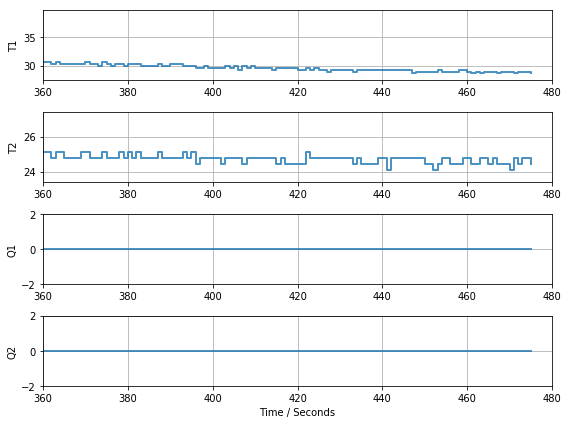

In [15]:
import tornado
import time
from tclab import setup, Historian, Plotter

SP = 40
Kp = 0

def update(lab):
    t = 0
    h = Historian(lab.sources)
    p = Plotter(h,120)
    while True:
        PV = lab.T1
        MV = Kp*(SP-PV)
        lab.U1 = MV
        p.update(t)
        yield
        t += 1

lab = setup(connected=True)
a = lab()

update_gen = update(a)

timer = tornado.ioloop.PeriodicCallback(lambda: next(update_gen), 1000)
timer.start()

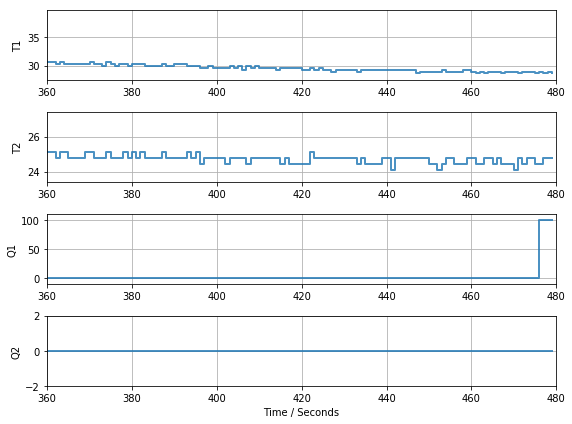

In [16]:
Kp = 10

In [17]:
timer.stop()
a.close()

TCLab disconnected successfully.


## Working with Widgets

In [39]:
from ipywidgets import interactive
from tclab import setup, clock, Historian, Plotter

def proportional(Kp):
    MV = 0
    while True:
        PV, SP = yield MV
        MV = Kp*(SP-PV)

def sim(Kp=1, SP=40):
    controller = proportional(Kp)
    controller.send(None)

    lab = setup(connected=False, speedup=20)
    with lab() as a:
        h = Historian(a.sources)
        p = Plotter(h,200)
        for t in clock(200):
            PV = a.T1
            MV = controller.send([PV,SP])
            a.U1 = MV
            h.update()
        p.update()   

interactive_plot = interactive(sim, Kp=(0,20,1), SP=(25,60,5), continuous_update=False);
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot

A Jupyter Widget